In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
# --- 0) 드라이브 마운트 & 경로 설정 (코랩이면)
from pathlib import Path
import pandas as pd

try:
  from google.colab import drive
  drive.mount('/content/drive')
  BASE = Path('/content/drive/MyDrive/2025_ML/Goodbooks-10k')
except:
  BASE = Path('./2025_ML/Goodbooks-10k')  # 로컬이면 여기 맞게 수정

# --- 1) 파일 목록
files = [
    "books.csv",
    "ratings.csv",
    "book_tags.csv",
    "tags.csv",
    "to_read.csv"
]

# --- 2) 각 파일 간단 요약 출력
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

for f in files:
    path = BASE / f
    print("\n" + "="*60)
    print(f"[{f}]  →  {path}")
    df = pd.read_csv(path, low_memory=False)
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} cols")
    print("Columns:", list(df.columns))
    print("\nDtypes:\n", df.dtypes)
    print("\nNA counts:\n", df.isna().sum())
    print("\nHead(3):\n", df.head(3))
    print("="*60)

# (옵션) XML 샘플도 있으면 한번에 보기
xml_path = BASE / "sample_book.xml"
if xml_path.exists():
    print("\n" + "="*60)
    print(f"[sample_book.xml]  →  {xml_path}")
    try:
        xml_df = pd.read_xml(xml_path)
        print(f"Shape: {xml_df.shape}")
        print("Columns:", list(xml_df.columns))
        print(xml_df.head(3))
    except Exception as e:
        print("XML 파싱 실패:", e)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

[books.csv]  →  /content/drive/MyDrive/2025_ML/Goodbooks-10k/books.csv
Shape: 10,000 rows × 23 cols
Columns: ['book_id', 'goodreads_book_id', 'best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 'original_title', 'title', 'language_code', 'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url']

Dtypes:
 book_id                        int64
goodreads_book_id              int64
best_book_id                   int64
work_id                        int64
books_count                    int64
isbn                          object
isbn13                       float64
authors                       object
original_publication_year    float64
original_title                object
title                  

In [ ]:
# -*- coding: utf-8 -*-
# Colab-ready: Goodbooks-10k 통합 병합 스크립트 (카티전 폭발 방지 버전)
# -------------------------------------------------------------
# 1) book_tags + tags -> goodreads_book_id별 태그 리스트 집계(tag_list)
# 2) books + tag_list (best_book_id == goodreads_book_id로 조인)
# 3) ratings + to_read -> to_read_flag 추가
# 4) (3) + (2)를 book_id로 LEFT JOIN
# 5) ID 정리: book_id(주키), best_book_id는 보조키(원하면 드롭)
# -------------------------------------------------------------

import pandas as pd
from pathlib import Path

# ==== 경로 설정(코랩 기준) ====
DATA_DIR = Path("/content/drive/MyDrive/2025_ML/Goodbooks-10k")   # 필요에 따라 수정
BOOKS_CSV      = DATA_DIR / "books.csv"
RATINGS_CSV    = DATA_DIR / "ratings.csv"
TO_READ_CSV    = DATA_DIR / "to_read.csv"
BOOK_TAGS_CSV  = DATA_DIR / "book_tags.csv"
TAGS_CSV       = DATA_DIR / "tags.csv"
OUTPUT_CSV     = "/content/goodbooks.csv"

# ==== 옵션 ====
TOPK = 0   # 0이면 전체 태그 사용, >0이면 상위 K개 태그만 사용
KEEP_GOODREADS_ID = True # True면 best_book_id를 보조 키로 유지, False면 드롭

# ==== 유틸 ====
def info(df, name):
    print(f"[{name}] shape={df.shape}")
    print(df.head(3))
    print("-"*60)

# ==== 0) 로드 ====
print(">>> Loading CSVs...")
books      = pd.read_csv(BOOKS_CSV)
ratings    = pd.read_csv(RATINGS_CSV)
to_read    = pd.read_csv(TO_READ_CSV)
book_tags  = pd.read_csv(BOOK_TAGS_CSV)
tags       = pd.read_csv(TAGS_CSV)

info(books, "books")
info(ratings, "ratings")
info(to_read, "to_read")
info(book_tags, "book_tags")
info(tags, "tags")

# ==== 1) 태그 집계: goodreads_book_id별 tag_name 리스트 ====
print(">>> Building tag_list per goodreads_book_id...")
# book_tags(goodreads_book_id, tag_id, count) + tags(tag_id, tag_name)
bt = book_tags.merge(tags, on="tag_id", how="left", validate="m:1")
bt = bt.dropna(subset=["tag_name"])  # 태그명 없는 것 제거

# 같은 (goodreads_book_id, tag_name)이 여러 번 나오면 count 합산
agg = (
    bt.groupby(["goodreads_book_id", "tag_name"], as_index=False)["count"]
      .sum()
)

# 책별로 count desc, tag_name asc 정렬
agg = agg.sort_values(["goodreads_book_id", "count", "tag_name"],
                      ascending=[True, False, True])

# 상위 K개만 선택 (TOPK>0인 경우)
if TOPK and TOPK > 0:
    agg = agg.groupby("goodreads_book_id", as_index=False).head(TOPK)

# 리스트(문자열)로 묶기 (쉼표 구분)
tag_list_df = (
    agg.groupby("goodreads_book_id")["tag_name"]
       .apply(lambda s: ",".join(s.tolist()))
       .reset_index()
       .rename(columns={"tag_name": "tag_list"})
)

# 참고: 태그 가중치 총합도 보관하고 싶다면 다음 라인 사용
tag_count_total_df = (
    agg.groupby("goodreads_book_id")["count"]
       .sum().reset_index()
       .rename(columns={"count": "tag_count_total"})
)

tag_df = tag_list_df.merge(tag_count_total_df, on="goodreads_book_id", how="left")
info(tag_df, "tag_df (goodreads aggregated)")

# ==== 2) books 확장: best_book_id == goodreads_book_id 로 태그 붙이기 ====
print(">>> Enriching books with tag_list via best_book_id == goodreads_book_id...")
books_enriched = books.merge(
    tag_df,
    left_on="best_book_id",
    right_on="goodreads_book_id",
    how="left",
    validate="m:1"
)

# 오른쪽 키 제거(중복 보정용)
if "goodreads_book_id" in books_enriched.columns:
    books_enriched = books_enriched.drop(columns=["goodreads_book_id"])

info(books_enriched, "books_enriched")

# ==== 3) ratings + to_read -> to_read_flag ====
print(">>> Building interactions (ratings + to_read_flag)...")
to_read_flag = to_read.copy()
to_read_flag["to_read_flag"] = True

interactions = ratings.merge(
    to_read_flag[["user_id", "book_id", "to_read_flag"]],
    on=["user_id", "book_id"],
    how="left",
    validate="m:1"
)
interactions["to_read_flag"] = interactions["to_read_flag"].fillna(False)

info(interactions, "interactions (ratings + to_read_flag)")

# ==== 4) 최종 병합: interactions + books_enriched (book_id로 LEFT JOIN) ====
print(">>> Joining interactions with books_enriched on book_id...")
final = interactions.merge(
    books_enriched,
    on="book_id",
    how="left",
    validate="m:1"
)

# ==== 5) ID 정리: 주키=book_id, 보조키(best_book_id)는 필요 시만 유지 ====
if not KEEP_GOODREADS_ID and "best_book_id" in final.columns:
    final = final.drop(columns=["best_book_id"])

# dtype/정렬 약간 정리(선택)
# 주요 컬럼들 앞으로 배치
front_cols = [c for c in ["user_id", "book_id", "rating", "to_read_flag", "best_book_id", "tag_list", "tag_count_total"] if c in final.columns]
other_cols = [c for c in final.columns if c not in front_cols]
final = final[front_cols + other_cols]



>>> Loading CSVs...
[books] shape=(10000, 23)
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn        isbn13                      authors  original_publication_year  \
0        1            2767052       2767052  2792775          272  439023483  9.780439e+12              Suzanne Collins                     2008.0   
1        2                  3             3  4640799          491  439554934  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2        3              41865         41865  3212258          226  316015849  9.780316e+12              Stephenie Meyer                     2005.0   

                             original_title                                              title language_code  average_rating  ratings_count  \
0                          The Hunger Games            The Hunger Games (The Hunger Games, #1)           eng            4.34        4780653   
1  Harry Potter and the Philosopher's Stone  Harry Potter and the S

/tmp/ipython-input-3112740316.py:112: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  interactions["to_read_flag"] = interactions["to_read_flag"].fillna(False)


[interactions (ratings + to_read_flag)] shape=(5976479, 4)
   user_id  book_id  rating  to_read_flag
0        1      258       5         False
1        2     4081       4         False
2        2      260       5         False
------------------------------------------------------------
>>> Joining interactions with books_enriched on book_id...


In [ ]:
final

,user_id,book_id,rating,to_read_flag,best_book_id,tag_list,tag_count_total,goodreads_book_id_x,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,goodreads_book_id_y
0,1,258,5,False,1232,"to-read,currently-reading,favorites,fiction,hi...",238281.0,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,The Shadow of the Wind (The Cemetery of Forgot...,eng,4.24,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...,1232.0
1,2,4081,4,False,231,"to-read,fiction,currently-reading,favorites,ow...",7388.0,231,1005335,53,312424442,9.780312e+12,Tom Wolfe,2004.0,NaN,I am Charlotte Simmons,en-US,3.40,19293,21580,1891,1481,2886,6557,6890,3766,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,231.0
2,2,260,5,False,4865,"non-fiction,to-read,self-improvement,nonfictio...",13938.0,4865,2370171,353,NaN,9.780672e+12,Dale Carnegie,1936.0,How to Win Friends and Influence People,How to Win Friends and Influence People,eng,4.13,282623,305437,7909,6734,13880,50529,94743,139551,https://images.gr-assets.com/books/1442726934m...,https://images.gr-assets.com/books/1442726934s...,4865.0
3,2,9296,5,False,4887,"to-read,psychology,non-fiction,nonfiction,self...",1758.0,4887,821815,75,465016901,9.780465e+12,"Alice Miller, Ruth Ward",1979.0,Das Drama des begabten Kindes und die Suche na...,The Drama of the Gifted Child: The Search for ...,en-GB,4.09,9563,10830,537,189,490,2025,3548,4578,https://images.gr-assets.com/books/1339395245m...,https://images.gr-assets.com/books/1339395245s...,4887.0
4,2,2318,3,False,998,"to-read,currently-reading,non-fiction,finance,...",44140.0,998,5210,43,671015206,9.780671e+12,"Thomas J. Stanley, William D. Danko",1995.0,The Millionaire Next Door: The Surprising Secr...,The Millionaire Next Door: The Surprising Secr...,eng,4.00,43937,46748,2049,645,2318,10382,16665,16738,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976474,49925,510,5,False,233649,"fantasy,fiction,wheel-of-time,favorites,epic-f...",18973.0,233649,1574475,71,812517725,9.780813e+12,Robert Jordan,1990.0,The Great Hunt,"The Great Hunt (Wheel of Time, #2)",en-US,4.20,162595,172500,3061,1824,5059,25119,64494,76004,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,233649.0
5976475,49925,528,4,False,34897,"to-read,fantasy,currently-reading,fiction,whee...",38422.0,34897,791061,62,765305119,9.780765e+12,Robert Jordan,1991.0,The Dragon Reborn,"The Dragon Reborn (Wheel of Time, #3)",eng,4.23,153809,164783,2471,1667,4474,23895,59113,75634,https://images.gr-assets.com/books/1480096580m...,https://images.gr-assets.com/books/1480096580s...,34897.0
5976476,49925,722,4,False,9539,"to-read,fantasy,currently-reading,fiction,whee...",34572.0,9539,6591373,83,812513738,9.780813e+12,Robert Jordan,1992.0,The Shadow Rising,"The Shadow Rising (Wheel of Time, #4)",en-US,4.21,122524,130562,2145,930,3327,20346,48728,57231,https://images.gr-assets.com/books/1470841890m...,https://images.gr-assets.com/books/1470841890s...,9539.0
5976477,49925,949,5,False,13895,"to-read,fantasy,currently-reading,wheel-of-tim...",32666.0,13895,588034,56,1857232097,9.781857e+12,Robert Jordan,1993.0,The Fires of Heaven,"The Fires of Heaven (Wheel of Time, #5)",en-US,4.13,93227,104317,1864,863,3367,18885,39542,41660,https://images.gr-assets.com/books/1327866286m...,https://images.gr-assets.com/books/1327866286s...,13895.0


In [ ]:
# --- 드롭 컬럼 정의 ---
drop_cols = [
    "to_read_flag", "work_id", "books_count", "isbn", "isbn13", "authors",
    "original_publication_year", "original_title", "language_code", "average_rating",
    "ratings_count", "work_ratings_count", "work_text_reviews_count",
    "ratings_1", "ratings_2", "ratings_3", "ratings_4", "ratings_5",
    "best_book_id", "goodreads_book_id_x", "goodreads_book_id_y", "id"
]

# --- 안전 드롭(정의된 컬럼만 + 존재하지 않으면 무시) ---
df = final.drop(columns=[c for c in drop_cols if c in final.columns]).copy()
# 또는 더 간단히:
# df = final.drop(columns=drop_cols, errors='ignore').copy()

print("드롭 후 shape:", df.shape)
print("남은 컬럼 예시:", df.columns[:10].tolist())


드롭 후 shape: (5976479, 8)
남은 컬럼 예시: ['user_id', 'book_id', 'rating', 'tag_list', 'tag_count_total', 'title', 'image_url', 'small_image_url']


In [ ]:
print("=== 기본 정보 ===")
print(df.info())

print("\n=== 결측치 요약 (상위 10개 컬럼) ===")
print(df.isna().sum().sort_values(ascending=False).head(10))


=== 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   user_id          int64  
 1   book_id          int64  
 2   rating           int64  
 3   tag_list         object 
 4   tag_count_total  float64
 5   title            object 
 6   image_url        object 
 7   small_image_url  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 364.8+ MB
None

=== 결측치 요약 (상위 10개 컬럼) ===
tag_list           181294
tag_count_total    181294
book_id                 0
user_id                 0
rating                  0
title                   0
image_url               0
small_image_url         0
dtype: int64


In [ ]:
# NAN 값 드롭
before = len(df)
df = df.dropna().reset_index(drop=True)
after = len(df)

print(f"✅ 결측치 제거 완료: {before - after}행 제거됨 (남은 행 {after:,})")
print(df.isna().sum().sum(), "개의 결측치 남음")  # 최종 확인

✅ 결측치 제거 완료: 181294행 제거됨 (남은 행 5,795,185)
0 개의 결측치 남음


In [ ]:
import zipfile

info(final, "FINAL (ready to save)")
print(">>> Saving to:", OUTPUT_CSV)
df.to_csv(OUTPUT_CSV, index=False)
print("✅ Done.")

# 압축할 파일명과 압축 결과 파일명 지정
input_file = "/content/goodbooks.csv"
output_zip = "/content/goodbooks.zip"

# ZIP 파일 생성 및 압축
with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(input_file)

print("✅ 압축 완료:", output_zip)


[FINAL (ready to save)] shape=(5976479, 29)
   user_id  book_id  rating  to_read_flag  best_book_id                                           tag_list  tag_count_total  goodreads_book_id_x  work_id  \
0        1      258       5         False          1232  to-read,currently-reading,favorites,fiction,hi...         238281.0                 1232  3209783   
1        2     4081       4         False           231  to-read,fiction,currently-reading,favorites,ow...           7388.0                  231  1005335   
2        2      260       5         False          4865  non-fiction,to-read,self-improvement,nonfictio...          13938.0                 4865  2370171   

   books_count       isbn        isbn13                          authors  original_publication_year                           original_title  \
0          279  143034901  9.780143e+12  Carlos Ruiz Zafón, Lucia Graves                     2001.0                     La sombra del viento   
1           53  312424442  9.780312e+12

>>> Loading goodbooks.csv...
✅ Loaded: 5,795,185 rows × 8 columns

=== 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5795185 entries, 0 to 5795184
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   user_id          int64  
 1   book_id          int64  
 2   rating           int64  
 3   tag_list         object 
 4   tag_count_total  float64
 5   title            object 
 6   image_url        object 
 7   small_image_url  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 353.7+ MB
None

=== 결측치 요약 (상위 10개 컬럼) ===
user_id            0
book_id            0
rating             0
tag_list           0
tag_count_total    0
title              0
image_url          0
small_image_url    0
dtype: int64

=== 샘플 5개 ===
         user_id  book_id  rating  \
4275849    34612      402       5   
2364617    30056      498       5   
169190      4653      265       5   
4254939    47895     3518       5   
1677273    24178     4737    

/tmp/ipython-input-1511973188.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette="viridis")


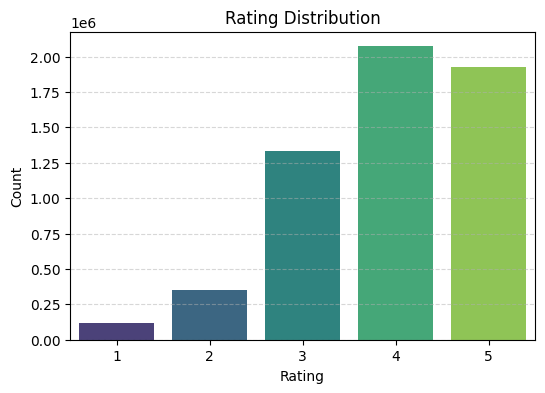


=== 사용자별 평점 수 통계 ===
count    53424.000000
mean       108.475311
std         25.485356
min         19.000000
25%         93.000000
50%        107.000000
75%        124.000000
max        196.000000
Name: rating, dtype: float64

=== 도서별 평점 수 통계 ===
count     9759.000000
mean       593.829798
std       1256.553454
min         11.000000
25%        155.000000
50%        248.000000
75%        502.000000
max      22806.000000
Name: rating, dtype: float64


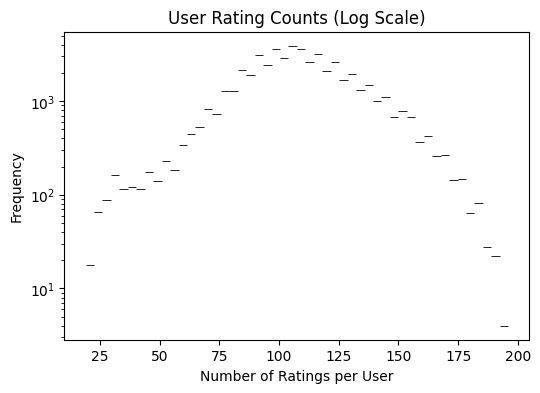


=== 태그 분포 분석 ===


In [ ]:
# -*- coding: utf-8 -*-
# Colab-ready: Goodbooks-10k final.csv 분석 스크립트
# -------------------------------------------------------------
# 기능:
# 1) 기본 구조/요약 (행수, 결측치, dtype)
# 2) 평점 통계 및 분포 시각화
# 3) 사용자/도서별 활동량 통계
# 4) 태그 관련 분석 (출현 빈도 Top-N)
# -------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === 경로 설정 ===
DATA_DIR = Path("/content/drive/MyDrive/ML/Goodbooks-10k")
FINAL_CSV = "/content/goodbooks.csv"

# === 0. 데이터 불러오기 ===
print(">>> Loading goodbooks.csv...")
df = pd.read_csv(FINAL_CSV)
print(f"✅ Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# === 1. 기본 구조 및 결측치 요약 ===
print("=== 기본 정보 ===")
print(df.info())

print("\n=== 결측치 요약 (상위 10개 컬럼) ===")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\n=== 샘플 5개 ===")
print(df.sample(5, random_state=42))

# === 2. 평점 관련 분석 ===
print("\n=== 평점 통계 ===")
print(df['rating'].describe())

plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df, palette="viridis")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# === 3. 사용자/도서별 활동량 분석 ===
user_activity = df.groupby('user_id')['rating'].count().describe()
book_activity = df.groupby('book_id')['rating'].count().describe()

print("\n=== 사용자별 평점 수 통계 ===")
print(user_activity)
print("\n=== 도서별 평점 수 통계 ===")
print(book_activity)

# 사용자별 평점 수 시각화 (로그 스케일)
plt.figure(figsize=(6,4))
sns.histplot(df.groupby('user_id')['rating'].count(), bins=50, log_scale=(False, True))
plt.title("User Rating Counts (Log Scale)")
plt.xlabel("Number of Ratings per User")
plt.ylabel("Frequency")
plt.show()

# === 4. 태그 분석 ===
if "tag_list" in df.columns:
    print("\n=== 태그 분포 분석 ===")

    # 태그 분리 후 출현 빈도 집계
    tag_series = (
        df['tag_list']
        .dropna()
        .str.split(',')
        .explode()
        .str.strip()
        .value_counts()
    )

    print("상위 20개 태그:")
    print(tag_series.head(20))

    plt.figure(figsize=(10,5))
    sns.barplot(x=tag_series.head(20).values, y=tag_series.head(20).index, palette="mako")
    plt.title("Top 20 Most Frequent Tags")
    plt.xlabel("Count")
    plt.ylabel("Tag")
    plt.show()


# === 6. 상관관계(평점-리뷰수 등) ===
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

print("✅ 분석 완료.")
